## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
import math

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set.csv")


# Quick inspection
tor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11959 entries, 0 to 11958
Data columns (total 35 columns):
DAMAGE_PROPERTY       11959 non-null float64
DURATION_SECONDS      11959 non-null float64
BEGIN_LAT             11959 non-null float64
BEGIN_LON             11959 non-null float64
TOR_LENGTH            11959 non-null float64
TOR_WIDTH             11959 non-null float64
YEAR                  11959 non-null float64
MULTI_VORT_IND        11959 non-null int64
OPEN_WATER_PROP       11959 non-null float64
DEV_OPEN_PROP         11959 non-null float64
DEV_LOW_PROP          11959 non-null float64
DEV_MED_PROP          11959 non-null float64
DEV_HIGH_PROP         11959 non-null float64
BARREN_LAND_PROP      11959 non-null float64
DECID_FOREST_PROP     11959 non-null float64
EVERGR_FOREST_PROP    11959 non-null float64
MIXED_FOREST_PROP     11959 non-null float64
SHRUB_SCRUB_PROP      11959 non-null float64
GRASS_LAND_PROP       11959 non-null float64
PASTURE_HAY_PROP      11959 non-null f

In [3]:
# Seperating variables
# The dependent variables
tornado_outcomes = tor_df.iloc[:, [0]]


# Quick inspection
tornado_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11959 entries, 0 to 11958
Data columns (total 1 columns):
DAMAGE_PROPERTY    11959 non-null float64
dtypes: float64(1)
memory usage: 93.5 KB


In [4]:
# The independent variables
tornado_features = tor_df.iloc[:, 2:34]

tornado_features = tornado_features.drop(["TOR_LENGTH",
                                          "TOR_WIDTH",
                                          "YEAR",
                                          "MULTI_VORT_IND",
                                          "TOR_AREA",
                                          "EXP_INC_AREA",
                                          "DAY_OF_YEAR",
                                          "MONTH"],
                                         axis = 1)


# Quick inspection
tornado_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11959 entries, 0 to 11958
Data columns (total 24 columns):
BEGIN_LAT             11959 non-null float64
BEGIN_LON             11959 non-null float64
OPEN_WATER_PROP       11959 non-null float64
DEV_OPEN_PROP         11959 non-null float64
DEV_LOW_PROP          11959 non-null float64
DEV_MED_PROP          11959 non-null float64
DEV_HIGH_PROP         11959 non-null float64
BARREN_LAND_PROP      11959 non-null float64
DECID_FOREST_PROP     11959 non-null float64
EVERGR_FOREST_PROP    11959 non-null float64
MIXED_FOREST_PROP     11959 non-null float64
SHRUB_SCRUB_PROP      11959 non-null float64
GRASS_LAND_PROP       11959 non-null float64
PASTURE_HAY_PROP      11959 non-null float64
CULT_CROPS_PROP       11959 non-null float64
WOOD_WETLAND_PROP     11959 non-null float64
HERB_WETLAND_PROP     11959 non-null float64
INCOME                11959 non-null float64
MOB_HOME_DENS         11959 non-null float64
POP_DENS              11959 non-null

In [5]:
# Make the dependent variables into a numpy array
outcomes_array = tornado_outcomes.values


# Makes the numpy array into a torch Tensor
outcomes_Tensor = torch.from_numpy(outcomes_array)


# Quick inspection
outcomes_Tensor


 0.1532
 0.6540
 0.0873
   ⋮    
-1.4219
 0.1532
 0.2814
[torch.DoubleTensor of size 11959x1]

In [6]:
# Make the independent variables into a numpy array
features_array = tornado_features.values


# Make the numpy array into a torch Tensor
features_Tensor = torch.from_numpy(features_array)


# Quick inspection
features_Tensor


-1.6434e+00 -4.3226e-01  1.0059e+00  ...   2.4012e-01  9.9841e-01 -8.0985e-01
 2.0633e-01  5.5447e-01  2.5095e-01  ...   6.0023e-01  2.2936e-01  5.1571e-01
-3.3130e-01 -8.9907e-01  6.5406e-01  ...  -5.8070e-01 -1.0991e+00 -1.1142e+00
                ...                   ⋱                   ...                
 1.1642e+00 -1.2164e+00  2.8103e-01  ...  -1.3975e+00 -1.6350e+00  7.8164e-01
-1.2487e+00  6.1127e-01  1.0901e-01  ...   9.1690e-01  4.8438e-01  2.6054e-01
-4.7014e-01 -3.4764e-02  1.6123e+00  ...   5.8210e-01 -4.3274e-01 -3.8082e-01
[torch.DoubleTensor of size 11959x24]

### Convert DoubleTensor to FloatTensor

In [7]:
# Changing dependent variables from a DoubleTensor to a FloatTensor
outcomes_Tensor = outcomes_Tensor.float()


# ...and for the independent variables
features_Tensor = features_Tensor.float()


# Quick check
features_Tensor


-1.6434e+00 -4.3226e-01  1.0059e+00  ...   2.4012e-01  9.9841e-01 -8.0985e-01
 2.0633e-01  5.5447e-01  2.5095e-01  ...   6.0023e-01  2.2936e-01  5.1571e-01
-3.3130e-01 -8.9907e-01  6.5406e-01  ...  -5.8070e-01 -1.0991e+00 -1.1142e+00
                ...                   ⋱                   ...                
 1.1642e+00 -1.2164e+00  2.8103e-01  ...  -1.3975e+00 -1.6350e+00  7.8164e-01
-1.2487e+00  6.1127e-01  1.0901e-01  ...   9.1690e-01  4.8438e-01  2.6054e-01
-4.7014e-01 -3.4764e-02  1.6123e+00  ...   5.8210e-01 -4.3274e-01 -3.8082e-01
[torch.FloatTensor of size 11959x24]

## Round 1: One-Hidden-Layer Neural Network

In [8]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [9]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 1))

In [10]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [11]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

In [12]:
# Get the iterations
iterations = list(range(0, 15000))

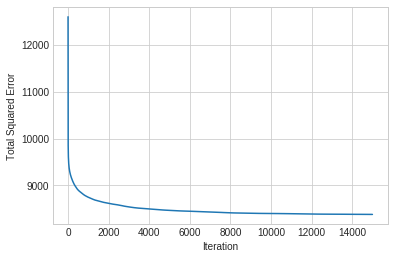

In [13]:
# Plot summed error as a function of iteration
plt.plot(iterations, errors)

plt.xlabel("Iteration")

plt.ylabel("Total Squared Error")

In [14]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()


# This is for the validation performance plot later
y_pred_array_for_perf = y_pred_resized.data.numpy()*5.407597 + 7.688844

y_pred_list_for_perf = y_pred_array_for_perf.tolist()

In [15]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
outcomes_Variable_resized = outcomes_Variable.resize(11959)


# Make the FloatTensor into a numpy.array
outcomes_array = outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
outcomes_list = outcomes_array.tolist()


# This is for the validation performance plot later
outcomes_array_for_perf = outcomes_Variable_resized.data.numpy()*5.407597 + 7.688844

outcomes_list_for_perf = outcomes_array_for_perf.tolist()

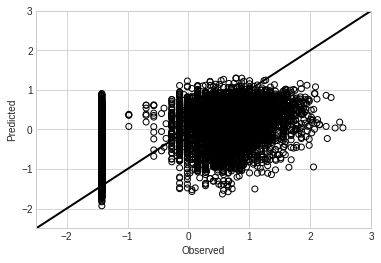

In [16]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, facecolors = "none", edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-2.5, 3])

axes.set_ylim([-2.5, 3])

plt.plot([-2.5, 3], [-2.5, 3], 'k-', lw = 2)

plt.xlabel("Observed")

plt.ylabel("Predicted")

### Round 1.1: Validation Set Performance

In [17]:
# Import data
valid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set.csv")


# Validation set outcomes
valid_outcomes = valid_df.iloc[:, [0]]


# Make the validation outcomes into a numpy array
valid_outcomes_array = valid_outcomes.values


# Makes the numpy array into a torch Tensor
valid_outcomes_Tensor = torch.from_numpy(valid_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
valid_outcomes_Tensor = valid_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_outcomes_Variable = Variable(valid_outcomes_Tensor)


# Quick check
valid_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3987 entries, 0 to 3986
Data columns (total 1 columns):
DAMAGE_PROPERTY    3987 non-null float64
dtypes: float64(1)
memory usage: 31.2 KB


In [18]:
# Validation set predictors
valid_predictors = valid_df.iloc[:, 2:34]

valid_predictors = valid_predictors.drop(["TOR_LENGTH",
                                          "TOR_WIDTH",
                                          "YEAR",
                                          "MULTI_VORT_IND",
                                          "TOR_AREA",
                                          "EXP_INC_AREA",
                                          "DAY_OF_YEAR",
                                          "MONTH"],
                                         axis = 1)


# Make the validation predictors into a numpy array
valid_predictors_array = valid_predictors.values


# Makes the numpy array into a torch Tensor
valid_predictors_Tensor = torch.from_numpy(valid_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
valid_predictors_Tensor = valid_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_predictors_Variable = Variable(valid_predictors_Tensor)


# Quick check
valid_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3987 entries, 0 to 3986
Data columns (total 24 columns):
BEGIN_LAT             3987 non-null float64
BEGIN_LON             3987 non-null float64
OPEN_WATER_PROP       3987 non-null float64
DEV_OPEN_PROP         3987 non-null float64
DEV_LOW_PROP          3987 non-null float64
DEV_MED_PROP          3987 non-null float64
DEV_HIGH_PROP         3987 non-null float64
BARREN_LAND_PROP      3987 non-null float64
DECID_FOREST_PROP     3987 non-null float64
EVERGR_FOREST_PROP    3987 non-null float64
MIXED_FOREST_PROP     3987 non-null float64
SHRUB_SCRUB_PROP      3987 non-null float64
GRASS_LAND_PROP       3987 non-null float64
PASTURE_HAY_PROP      3987 non-null float64
CULT_CROPS_PROP       3987 non-null float64
WOOD_WETLAND_PROP     3987 non-null float64
HERB_WETLAND_PROP     3987 non-null float64
INCOME                3987 non-null float64
MOB_HOME_DENS         3987 non-null float64
POP_DENS              3987 non-null float64
TOT_DEV_INT  

In [19]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Get the loss - (total) residual sum of squares
total_SE = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Average that to get mean square error
mean_SE = total_SE / len(y_valid_pred)

mean_SE

Variable containing:
 0.7938
[torch.FloatTensor of size 1]

In [20]:
# Computing the total sum of squares
# Get a torch Variable of the mean outcome
# Compute mean value
valid_outcomes_mean = (sum(valid_outcomes_Variable) / len(valid_outcomes_Variable))
valid_outcomes_mean = valid_outcomes_mean.data.numpy()[0]

# Make that into a ndarray
valid_outcomes_mean = np.repeat(valid_outcomes_mean, len(valid_outcomes_Variable))

# Turn the array into a torch Tensor
valid_outcomes_mean = torch.from_numpy(valid_outcomes_mean)

# Turn that Tensor into a Variable
valid_outcomes_mean_Variable = Variable(valid_outcomes_mean)

# Compute the TSS
tot_sum_squares = loss_fn(valid_outcomes_mean_Variable, valid_outcomes_Variable)


# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.1957
[torch.FloatTensor of size 1]

In [21]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

In [22]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
valid_outcomes_Variable_resized = valid_outcomes_Variable.resize(3987)


# Make the FloatTensor into a numpy.array
valid_outcomes_array = valid_outcomes_Variable_resized.data.numpy()


# Convert back to log scale
valid_outcomes_array = valid_outcomes_array*5.407597 + 7.688844


# Make the numpy.array into a list
valid_outcomes_list = valid_outcomes_array.tolist()

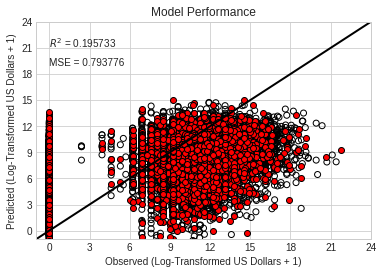

In [23]:
# Plot new predictions versus new data outcomes
plt.scatter(outcomes_list_for_perf, y_pred_list_for_perf, facecolors = "none",
            edgecolors = "k")

plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "r",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

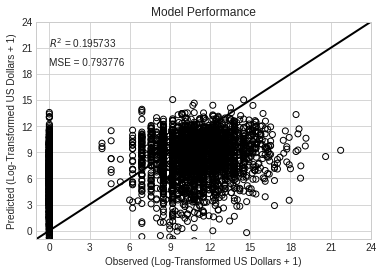

In [24]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "none",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

In [25]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.4522 -0.2483  0.0908  0.0611 -0.1421 -0.4207 -0.2922  0.1867 -0.0584  0.1187
 0.1441 -0.0832  0.0896  0.1693  0.2531  0.1525  0.0204 -0.0018 -0.0205 -0.1392
 0.3666  0.5044  0.0966 -0.0538 -0.0620  0.0179 -0.0440 -0.1620  0.1829 -0.2351
 0.4335  0.1635  0.2532  0.1895 -0.2123 -0.1599  0.1446 -0.0202 -0.1590 -0.1871
 0.0527  0.4063  0.0650  0.1191 -0.0572  0.0238  0.0085 -0.0106  0.1053  0.1148
 0.1697 -0.1496  0.2796  0.3390  0.2588  0.1321 -0.2698 -0.0264  0.1514  0.5301
 0.2636  0.5054 -0.1904 -0.4361  0.0230  0.1014  0.0309 -0.0372 -0.3435  0.1705
-0.0400 -0.1415  0.0908  0.3795 -0.1362 -0.0099  0.0392 -0.1193 -0.1892 -0.1629
-0.7055 -0.2234  0.0477  0.0882  0.3968  0.0280  0.0547 -0.0632 -0.3077 -0.1924
 0.0608  0.2299 -0.0142  0.2273 -0.0516 -0.0276  0.2984 -0.0084 -0.2643  0.5042
-0.2886 -0.2351 -0.0274 -0.3072 -0.0256  0.1463  0.0283 -0.1378  0.0736  0.0171
-0.1790  0.1696  0.2163 -0.1967  0.5204  0.1107 -0.1887  0.0711 -0.3711  0.0706
-

## Round 2: Two-Hidden-Layer Neural Network

In [26]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [27]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 1))

In [28]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

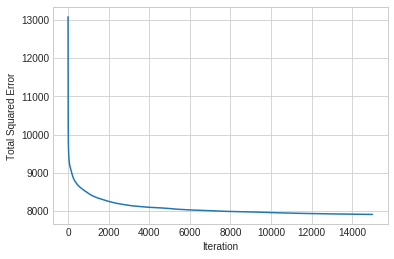

In [29]:
# Plot summed error as a function of iteration
plt.plot(iterations, errors)

plt.xlabel("Iteration")

plt.ylabel("Total Squared Error")

In [30]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()


# This is for the validation performance plot later
y_pred_array_for_perf = y_pred_resized.data.numpy()*5.407597 + 7.688844

y_pred_list_for_perf = y_pred_array_for_perf.tolist()

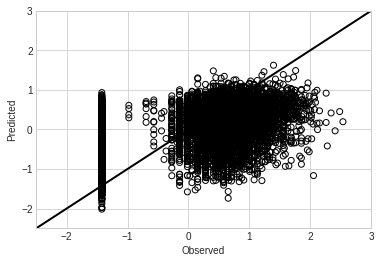

In [31]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, facecolors = "none", edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-2.5, 3])

axes.set_ylim([-2.5, 3])

plt.plot([-2.5, 3], [-2.5, 3], 'k-', lw = 2)

plt.xlabel("Observed")

plt.ylabel("Predicted")

### Round 2.1: Validation Set Performance

In [32]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Get the loss - (total) residual sum of squares
total_SE = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Average that to get mean square error
mean_SE = total_SE / len(y_valid_pred)

mean_SE

Variable containing:
 0.7853
[torch.FloatTensor of size 1]

In [33]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.2043
[torch.FloatTensor of size 1]

In [34]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

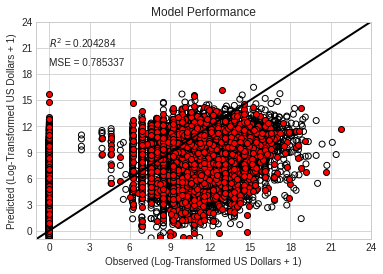

In [35]:
# Plot new predictions versus new data outcomes
plt.scatter(outcomes_list_for_perf, y_pred_list_for_perf, facecolors = "none",
            edgecolors = "k")

plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "r",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

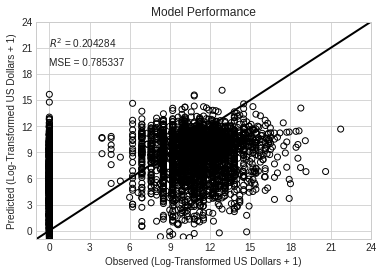

In [36]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "none",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

In [37]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.1456  0.2600  0.0498 -0.1346  0.0715 -0.1519 -0.2049  0.0195  0.0790 -0.0554
 0.0815 -0.4474 -0.0699  0.0477  0.3040 -0.1912 -0.0823  0.1236 -0.1066  0.0798
 0.0825 -0.2312  0.1729  0.1683  0.1002 -0.2738 -0.0435  0.0542 -0.0505  0.2773
-0.3331 -0.2314  0.1564  0.6283 -0.4410  0.5181 -0.4260  0.1198  0.0638  0.0181
-0.2335  0.1371 -0.0963 -0.0572  0.0737 -0.2512  0.1418 -0.2317  0.2300  0.1578
-0.2403 -0.1426 -0.0457  0.0649 -0.1544 -0.0665  0.0182 -0.0290 -0.1606  0.0444
-0.1964 -0.1272  0.0737  0.1341  0.0346 -0.0241  0.0757 -0.1365  0.0089  0.0661
-0.5016  0.1601  0.2776 -0.0595 -0.2039  0.0337  0.1968 -0.2006  0.1087  0.3171
 0.0055 -0.2566  0.1854  0.3151 -0.6065  0.5710 -0.1321 -0.0440 -0.1671 -0.0448
 0.4862 -0.3780  0.1995  0.0347  0.1150 -0.0381 -0.3410  0.1072 -0.1947  0.3454
 0.5801 -0.2660 -0.0360 -0.1777  0.2819  0.0928 -0.1091 -0.2079 -0.7038 -0.0115
-0.8748  0.1649  0.0300 -0.3874  0.2036  0.4647  0.1617  0.0958 -0.0109  0.3968
-

## Round 3: Three-Hidden-Layer Neural Network

In [38]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [39]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 1))

In [40]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

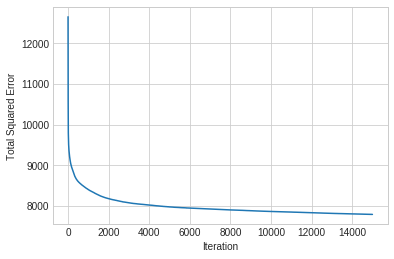

In [41]:
# Plot summed error as a function of iteration
plt.plot(iterations, errors)

plt.xlabel("Iteration")

plt.ylabel("Total Squared Error")

In [42]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()


# This is for the validation performance plot later
y_pred_array_for_perf = y_pred_resized.data.numpy()*5.407597 + 7.688844

y_pred_list_for_perf = y_pred_array_for_perf.tolist()

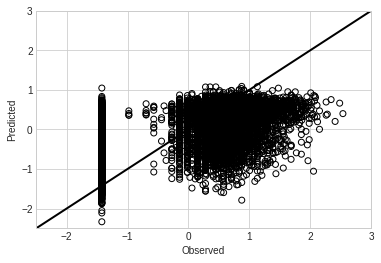

In [43]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, facecolors = "none", edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-2.5, 3])

axes.set_ylim([-2.5, 3])

plt.plot([-2.5, 3], [-2.5, 3], 'k-', lw = 2)

plt.xlabel("Observed")

plt.ylabel("Predicted")

### Round 3.1: Validation Set Performance

In [44]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Get the loss - (total) residual sum of squares
total_SE = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Average that to get mean square error
mean_SE = total_SE / len(y_valid_pred)

mean_SE

Variable containing:
 0.8199
[torch.FloatTensor of size 1]

In [45]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.1693
[torch.FloatTensor of size 1]

In [46]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

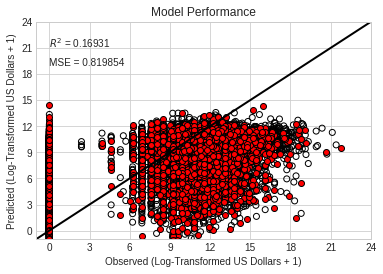

In [47]:
# Plot new predictions versus new data outcomes
plt.scatter(outcomes_list_for_perf, y_pred_list_for_perf, facecolors = "none",
            edgecolors = "k")

plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "r",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

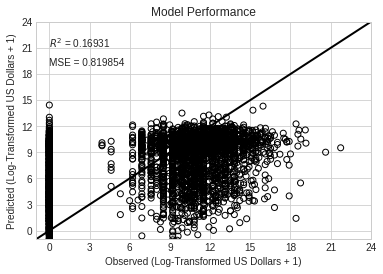

In [48]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "none",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

In [49]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.0424 -0.3421  0.1334 -0.0151  0.0087 -0.1231 -0.0291  0.0776 -0.0765  0.0351
-0.1512 -0.0109  0.2347 -0.2743  0.0018  0.3078 -0.0055 -0.0858 -0.4514 -0.4401
 0.3247  0.1742  0.0713  0.1957 -0.2618  0.0956  0.2703  0.0724 -0.1654 -0.1512
 0.1882  0.0335  0.1587  0.2598 -0.0458 -0.1983  0.4304 -0.1907 -0.0796 -0.1159
-0.3168  0.1256  0.0339  0.0206 -0.0771  0.1035 -0.1009  0.1529 -0.0548  0.2219
 0.0287  0.2680 -0.2646 -0.1379 -0.2750 -0.2854  0.5024  0.2026  0.0779  0.0111
-0.0386  0.0528  0.0846  0.3486 -0.0953  0.1167 -0.0863 -0.0124 -0.2370  0.1310
 0.0349 -0.1297 -0.0923  0.1689  0.1223 -0.1192  0.0486 -0.0557 -0.0357 -0.1520
 0.6105 -0.2445 -0.1125 -0.3149  0.3278  0.4632  0.1210 -0.0943 -0.3075 -0.1687
 0.1758  0.0736 -0.3004 -0.1570  0.3351  0.1426  0.0006 -0.1214  0.3259 -0.3994
 0.3390 -0.1081  0.0000  0.1047 -0.1916 -0.0464  0.2356  0.0656  0.0618 -0.3231
 0.2552 -0.2540 -0.0187  0.1735  0.1471  0.2652 -0.0224  0.2029  0.1019 -0.5492
 

## Round 4: Four-Hidden-Layer Neural Network

In [50]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [51]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 1))

In [52]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

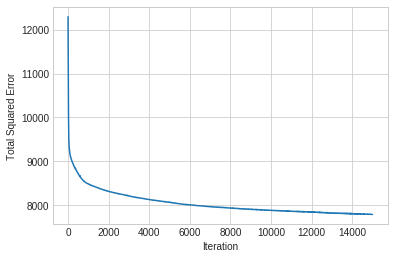

In [53]:
# Plot summed error as a function of iteration
plt.plot(iterations, errors)

plt.xlabel("Iteration")

plt.ylabel("Total Squared Error")

In [54]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()


# This is for the validation performance plot later
y_pred_array_for_perf = y_pred_resized.data.numpy()*5.407597 + 7.688844

y_pred_list_for_perf = y_pred_array_for_perf.tolist()

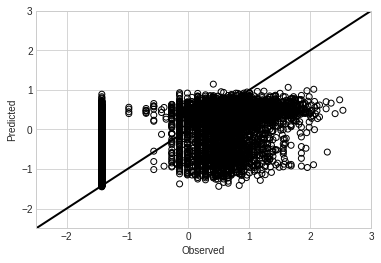

In [55]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, facecolors = "none", edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-2.5, 3])

axes.set_ylim([-2.5, 3])

plt.plot([-2.5, 3], [-2.5, 3], 'k-', lw = 2)

plt.xlabel("Observed")

plt.ylabel("Predicted")

### Round 4.1: Validation Set Performance

In [56]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Get the loss - (total) residual sum of squares
total_SE = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Average that to get mean square error
mean_SE = total_SE / len(y_valid_pred)

mean_SE

Variable containing:
 0.8045
[torch.FloatTensor of size 1]

In [57]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.1849
[torch.FloatTensor of size 1]

In [58]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

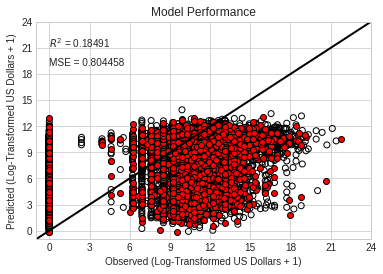

In [59]:
# Plot new predictions versus new data outcomes
plt.scatter(outcomes_list_for_perf, y_pred_list_for_perf, facecolors = "none",
            edgecolors = "k")

plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "r",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

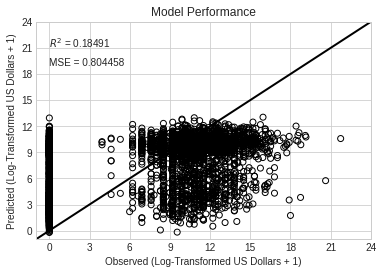

In [60]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "none",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

In [61]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.3271  0.0150 -0.0694 -0.0735 -0.0101  0.1799  0.2069  0.1488 -0.4481  0.0777
-0.1896  0.7788 -0.2522  0.2870 -0.2742 -0.1046  0.2518 -0.2662  0.2224 -0.2047
 0.1022 -0.2792 -0.0734 -0.2669 -0.2627 -0.0496  0.1586 -0.1327  0.0480  0.1296
 0.2646 -0.0127 -0.0540  0.0715 -0.3614 -0.2860  0.2456 -0.1888  0.3673 -0.2223
 0.2239  0.0054  0.1966  0.0457  0.0007 -0.0914  0.1115 -0.2795 -0.0318 -0.3756
-0.3040 -0.0920 -0.1131  0.1018  0.1025 -0.3067  0.1583 -0.0717  0.2124  0.1069
-0.3244  0.1409  0.1555  0.0975 -0.2157 -0.1821  0.2234  0.2333  0.0509 -0.3828
 0.5652 -0.3827  0.2278 -0.2665 -0.3175  0.0233 -0.0765 -0.2653 -0.1156 -0.2861
-0.0653  0.0642 -0.2021 -0.0297 -0.0240 -0.2417 -0.0711  0.3458 -0.0120 -0.1565
 0.4838 -0.1371  0.0097  0.2458 -0.3574 -0.0992  0.0932  0.0504  0.0188  0.0513
 0.2387  0.0996 -0.2417 -0.2503  0.1444 -0.0512  0.0532  0.0727 -0.0525  0.0982
-0.0514  0.0258  0.1807  0.4274 -0.3491  0.2420 -0.3524 -0.0600  0.2593  0.4077
 

## Round 5: Five-Hidden-Layer Neural Network

In [62]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [63]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 1))

In [64]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

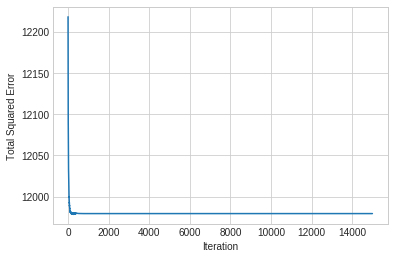

In [65]:
# Plot summed error as a function of iteration
plt.plot(iterations, errors)

plt.xlabel("Iteration")

plt.ylabel("Total Squared Error")

In [66]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()


# This is for the validation performance plot later
y_pred_array_for_perf = y_pred_resized.data.numpy()*5.407597 + 7.688844

y_pred_list_for_perf = y_pred_array_for_perf.tolist()

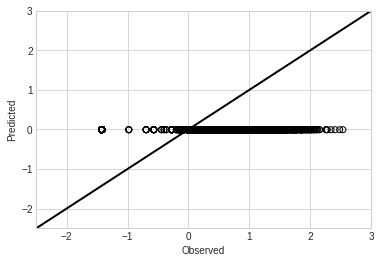

In [67]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, facecolors = "none", edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-2.5, 3])

axes.set_ylim([-2.5, 3])

plt.plot([-2.5, 3], [-2.5, 3], 'k-', lw = 2)

plt.xlabel("Observed")

plt.ylabel("Predicted")

### Round 5.1: Validation Set Performance

In [68]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Get the loss - (total) residual sum of squares
total_SE = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Average that to get mean square error
mean_SE = total_SE / len(y_valid_pred)

mean_SE

Variable containing:
 0.9874
[torch.FloatTensor of size 1]

In [69]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
1.00000e-04 *
 -4.6194
[torch.FloatTensor of size 1]

In [70]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

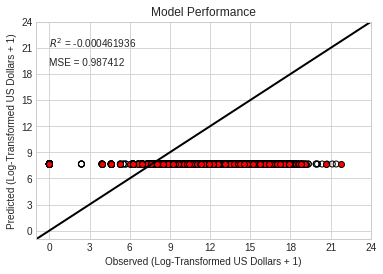

In [71]:
# Plot new predictions versus new data outcomes
plt.scatter(outcomes_list_for_perf, y_pred_list_for_perf, facecolors = "none",
            edgecolors = "k")

plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "r",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

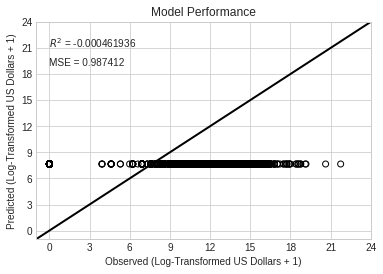

In [72]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "none",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

In [73]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.1032 -0.1165  0.0910  0.0532  0.0554  0.0608 -0.1681  0.0748  0.1609  0.1312
-0.1492  0.0467  0.0550  0.1502  0.0564 -0.1137  0.0642  0.1522 -0.0096 -0.1521
 0.1339  0.1357 -0.0859  0.0482  0.2025  0.0134  0.0508  0.1336 -0.1093 -0.1523
-0.1657 -0.0735 -0.0743 -0.1838 -0.1129  0.0734 -0.1979  0.0203  0.1387  0.1451
-0.0210 -0.0001 -0.1060 -0.0032  0.1917  0.0943  0.0223 -0.1941 -0.1419  0.1945
 0.1412  0.1822  0.0313 -0.0391  0.0036  0.0077 -0.1411 -0.0486  0.1754  0.1669
-0.1245  0.0433 -0.0377 -0.0245 -0.0625  0.0649 -0.0342 -0.0244 -0.1243  0.1820
 0.1172 -0.1745  0.1156 -0.0366  0.0799  0.0867 -0.0201 -0.0433  0.0450  0.0577
 0.1587 -0.0332 -0.1377 -0.1482  0.1669 -0.0042 -0.0155 -0.1105  0.0267  0.0650
-0.1795 -0.0045  0.0353 -0.0930  0.0958 -0.1835 -0.0898 -0.1381  0.1109  0.0925
-0.0340  0.1421 -0.1152  0.1564 -0.1772  0.0225  0.0631  0.1119  0.0381 -0.1065
-0.0601 -0.1241  0.1795  0.0958 -0.0297 -0.1933 -0.0861 -0.1536 -0.0294  0.1221
-

## Round 6: Six-Hidden-Layer Neural Network

In [74]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [75]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(2, 1))

In [76]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

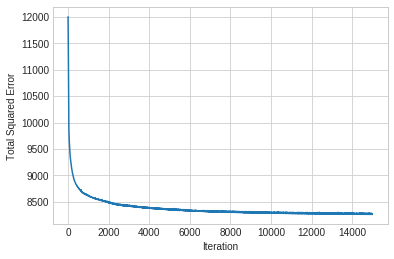

In [77]:
# Plot summed error as a function of iteration
plt.plot(iterations, errors)

plt.xlabel("Iteration")

plt.ylabel("Total Squared Error")

In [78]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()


# This is for the validation performance plot later
y_pred_array_for_perf = y_pred_resized.data.numpy()*5.407597 + 7.688844

y_pred_list_for_perf = y_pred_array_for_perf.tolist()

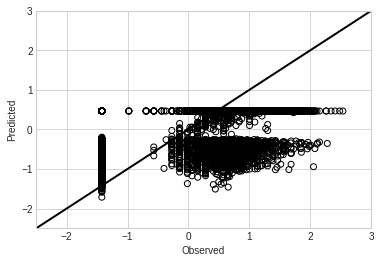

In [79]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, facecolors = "none", edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-2.5, 3])

axes.set_ylim([-2.5, 3])

plt.plot([-2.5, 3], [-2.5, 3], 'k-', lw = 2)

plt.xlabel("Observed")

plt.ylabel("Predicted")

### Round 6.1: Validation Set Performance

In [80]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Get the loss - (total) residual sum of squares
total_SE = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Average that to get mean square error
mean_SE = total_SE / len(y_valid_pred)

mean_SE

Variable containing:
 0.8141
[torch.FloatTensor of size 1]

In [81]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.1752
[torch.FloatTensor of size 1]

In [82]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

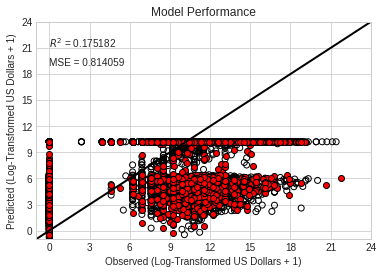

In [83]:
# Plot new predictions versus new data outcomes
plt.scatter(outcomes_list_for_perf, y_pred_list_for_perf, facecolors = "none",
            edgecolors = "k")

plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "r",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

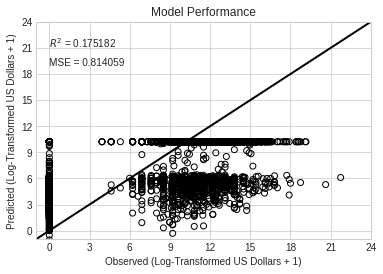

In [84]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "none",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

In [85]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.1610 -0.2658  0.2742 -0.2204  0.0327 -0.1570  0.0809  0.0038 -0.2290  0.0980
 0.2184 -0.1597  0.0079  0.1699 -0.0583 -0.0379  0.1007 -0.3210  0.0105 -0.0352
-0.0001  0.1390  0.0541  0.3101 -0.3092 -0.0242 -0.1353  0.1454  0.2729  0.1384
 0.5380 -0.3868 -0.2768  0.0042 -0.0280 -0.1495  0.1048 -0.0961 -0.0012 -0.2011
 0.0694 -0.2760  0.2106  0.5085 -0.2269  0.1910 -0.2066 -0.1698  0.1493  0.1718
 0.3454  0.2290 -0.0677 -0.4364 -0.0609 -0.1914  0.0056  0.2446 -0.2706 -0.4198
 0.2137  0.0191 -0.0516 -0.2132  0.2065 -0.0608  0.0515 -0.0938 -0.1646 -0.2860
-0.0134 -0.3921 -0.1376  0.0984 -0.2127 -0.1342 -0.1888  0.0222 -0.0520 -0.1458
 0.4486 -0.2048 -0.2309 -0.2793 -0.0741 -0.1529 -0.2835  0.0077  0.1551 -0.2714
 0.1192 -0.2232 -0.0183  0.2480 -0.2224 -0.0558  0.0222 -0.1647 -0.1478  0.0649
 0.0941  0.2689 -0.5187 -0.5200 -0.0144  0.0822 -0.0608  0.0044 -0.3042 -0.2348
 0.2339  0.4400  0.0092 -0.2187 -0.0346  0.1891  0.0897 -0.1474  0.3250  0.3447
 

## Round 7: Linear Regression

In [86]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [87]:
# Make the neural network - really a regression
model = torch.nn.Sequential(torch.nn.Linear(24, 1))

In [88]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

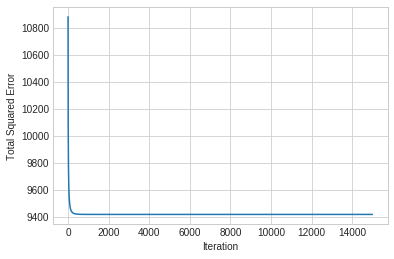

In [89]:
# Plot summed error as a function of iteration
plt.plot(iterations, errors)

plt.xlabel("Iteration")

plt.ylabel("Total Squared Error")

In [90]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()


# This is for the validation performance plot later
y_pred_array_for_perf = y_pred_resized.data.numpy()*5.407597 + 7.688844

y_pred_list_for_perf = y_pred_array_for_perf.tolist()

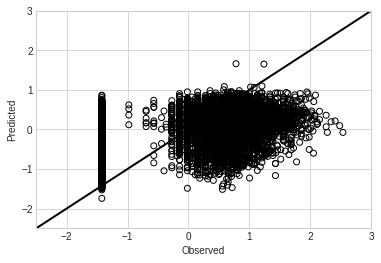

In [91]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, facecolors = "none", edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-2.5, 3])

axes.set_ylim([-2.5, 3])

plt.plot([-2.5, 3], [-2.5, 3], 'k-', lw = 2)

plt.xlabel("Observed")

plt.ylabel("Predicted")

### Round 7.1: Validation Set Performance

In [92]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Get the loss - (total) residual sum of squares
total_SE = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Average that to get mean square error
mean_SE = total_SE / len(y_valid_pred)

mean_SE

Variable containing:
 0.8010
[torch.FloatTensor of size 1]

In [93]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.1884
[torch.FloatTensor of size 1]

In [94]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

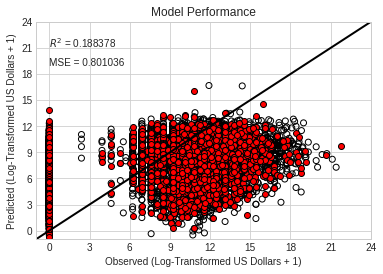

In [95]:
# Plot new predictions versus new data outcomes
plt.scatter(outcomes_list_for_perf, y_pred_list_for_perf, facecolors = "none",
            edgecolors = "k")

plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "r",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

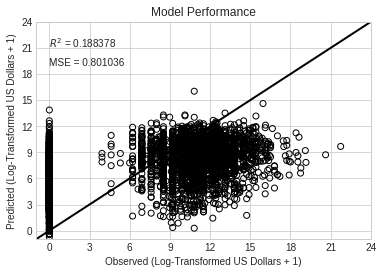

In [96]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "none",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

In [97]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.0067  0.1077 -0.0015 -0.0139 -0.0026 -0.0726  0.0407 -0.0035  0.0946  0.0910

Columns 10 to 19 
-0.0042 -0.0199 -0.0581  0.0439  0.0158  0.0277  0.0026 -0.1834 -0.0436  0.1716

Columns 20 to 23 
 0.1334  0.0091  0.0441  0.0474
[torch.FloatTensor of size 1x24]